In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rc("font", family = "Malgun Gothic")
matplotlib.rc("axes", unicode_minus = False)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

from sklearn import set_config
set_config(print_changed_only = False)

import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as os

import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 5000

pd.options.display.max_rows = 1000

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### WBR_상관관계 분석 



**[방향성]**

- 매출에 영향을 주는 요소가 아래와 같이 많은 관계로 인해 별도 컬럼을 선정해서 독립적으로 조사를 진행한다.**
- 'GMV (취소포함)'을 종속변수로, 이에 대응하는 '주문건수 (취소포함)', '사용자 유입수','구매전환율', '평균객단가', '손익매출 (취소제외)', '주문건수 (취소제외)', '평균 손익객단가'를 독립변수로 선정한 뒤 데이터를 추가한다**


In [43]:
train = pd.read_excel("Downloads/오늘식탁 WBR Template.xlsx", header = 2, sheet_name = "상관관계분석 데이터")
train_fix = train.iloc[ : ,  4 : -7]

**[데이터 로드]**

In [16]:
train_fix1 = train_fix[['GMV (취소포함)', '주문건수 (취소포함)', '사용자 유입수','구매전환율', '평균객단가', '손익매출 (취소제외)', '주문건수 (취소제외)', '평균 손익객단가']].head()
# print(train_fix1.shape)
train_fix1.head()

,GMV (취소포함),주문건수 (취소포함),사용자 유입수,구매전환율,평균객단가,손익매출 (취소제외),주문건수 (취소제외),평균 손익객단가
0,337388780,5122.0,218078,0.023487,65870.515424,321957766.0,4955,64976.340262
1,492908190,8191.0,452930,0.018084,60176.802588,471504605.0,7942,59368.497230
2,450749000,7353.0,429634,0.017115,61301.373589,431292195.0,7132,60472.825996
3,383055680,6231.0,508412,0.012256,61475.795217,367854170.0,6072,60582.043808
4,389613630,6302.0,516193,0.012209,61823.806728,399139348.0,6723,59369.232188


**[상관관계 분석]**

- 상관관계 분석 결과 GMV에 가장 큰 영향을 미치는 것은 : '주문건수'"로 99.6%의 영향을 보인다

In [17]:
train_fix1.corr().head(1)

,GMV (취소포함),주문건수 (취소포함),사용자 유입수,구매전환율,평균객단가,손익매출 (취소제외),평균 손익객단가
GMV (취소포함),1.0,0.996788,0.452431,-0.130381,-0.831819,0.979546,-0.705826


-  주문건수가 주문내역을 조회해서 주문건수에 영향을 미치는 것에 무엇이 있는지, 혹은 가장 큰 영향을 주는 변수들이 무엇인지 분석한다
- 데이터 출처 : '마케팅/주문내역 데이터' 2021/07/01~2021/09/30 조회기간 산정

In [18]:
train_주문내역 = pd.read_csv("Downloads/주문내역 데이터_2021-09-30 04_34_09 PM.csv")
train_주문내역2 = pd.read_csv("Downloads/주문내역 데이터_2021-10-01 09_20_57 AM.csv")

train_주문내역 = pd.concat([train_주문내역, train_주문내역2],  axis=0)
train_종류파악 = pd.read_csv("Downloads/[Lastweek] product type_2021-09-30 04_53_38 PM.csv")

train_주문내역_수정 = pd.merge(train_주문내역, train_종류파악, left_on = "SKU 코드", right_on = "sku코드",  how = "left")

=========================================================================================

#### **추가 컬럼 생성 - Data Analysis**

**[필요한 데이터 수집]**
- 주문시간 - 시간 확인을 위해 필요 
- 상품상태 - 결제 취소 등등을 비교하기 위해 
- 'SKU 판매가', '매입가',  '쿠폰사용금액','종류' -  매출비교분석을 위함

In [19]:
train_주문내역_수정_data = train_주문내역_수정[['주문시간','상품상태','SKU 판매가', '매입가',  '쿠폰사용금액','종류']]

train_주문내역_수정_data.head()
print(train_주문내역_수정_data.shape)

,주문시간,상품상태,SKU 판매가,매입가,쿠폰사용금액,종류
0,2021-09-30 16:30:31,결제완료,3900,1980,0,냉동
1,2021-09-30 16:30:31,결제완료,16900,10500,0,당일입고
2,2021-09-30 16:30:31,결제완료,0,0,0,당일입고
3,2021-09-30 16:30:31,결제완료,19900,11700,18910,당일입고
4,2021-09-30 16:30:31,결제완료,0,250,0,당일입고


(710633, 6)


**[데이터 추가]**
- 마진 생성 -> 판매가 - 매입가
- 가격범위 설정 -> 10000원 단위로 5개 생성, 0이하는 전부 '취소'로 정리
- 더미변수 생성해서 데이터 분석에 활용하기
- 날짜변환 진행

In [62]:
train_주문내역_수정_data["마진"] = train_주문내역_수정_data["SKU 판매가"] - train_주문내역_수정_data["매입가"]

def divide_price_ratio(number):
    
    if number <= 0:
        return "취소"
    
    if number < 10000:
        return "10000원 미만"
    
    if 10000 <= number < 20000:
        return "10000 ~ 20000"
    
    if 20000 <= number < 30000:
        return "20000 ~ 30000"
    
    if 30000 <= number < 40000:
        return "30000 ~ 40000"
    
    if 40000 <= number < 50000:
        return "40000 ~ 50000"
    
    if 50000 <= number :
        return "50000원 이상"
    
   
train_주문내역_수정_data["가격범위"] = train_주문내역_수정_data["SKU 판매가"].apply(divide_price_ratio)
train_종류파악["가격범위"] = train_종류파악["판매가"].apply(divide_price_ratio)
pd.DataFrame(train_주문내역_수정_data["가격범위"].value_counts())

print("===================================================================================")

# 더미변수 생성
data = pd.get_dummies(train_주문내역_수정_data["종류"], prefix = "종류_")
train_주문내역_수정_data = pd.concat([train_주문내역_수정_data, data], axis = 1)
train_주문내역_수정_data.head()

,가격범위
취소,299498
10000원 미만,183259
10000 ~ 20000,148770
20000 ~ 30000,55893
30000 ~ 40000,9523
50000원 이상,7969
40000 ~ 50000,5721


,주문시간,상품상태,SKU 판매가,매입가,쿠폰사용금액,종류,마진,가격범위,종류__냉동,종류__냉장,종류__당일입고,종류__상온,종류__냉동,종류__냉장,종류__당일입고,종류__상온
0,2021-09-30 16:30:31,결제완료,3900,1980,0,냉동,1920,10000원 미만,1,0,0,0,1,0,0,0
1,2021-09-30 16:30:31,결제완료,16900,10500,0,당일입고,6400,10000 ~ 20000,0,0,1,0,0,0,1,0
2,2021-09-30 16:30:31,결제완료,0,0,0,당일입고,0,취소,0,0,1,0,0,0,1,0
3,2021-09-30 16:30:31,결제완료,19900,11700,18910,당일입고,8200,10000 ~ 20000,0,0,1,0,0,0,1,0
4,2021-09-30 16:30:31,결제완료,0,250,0,당일입고,-250,취소,0,0,1,0,0,0,1,0


**[매입가 제거]**
- 매입가 0인 것들은 부가적으로 가는 간장, 소스 같은 것들이라 제외한다
- 매입가를 기준으로는 각 종류별 원가 , 판매상품 이외의 비용 정도를 체크해본다

In [59]:
train_주문내역_수정_매입가조정 = train_주문내역_수정_data[~(train_주문내역_수정_data['매입가'] == 0)]
train_주문내역_수정_매입가조정.head(2)

,주문시간,상품상태,SKU 판매가,매입가,쿠폰사용금액,종류,마진,가격범위,종류__냉동,종류__냉장,종류__당일입고,종류__상온
0,2021-09-30 16:30:31,결제완료,3900,1980,0,냉동,1920,10000원 미만,1,0,0,0
1,2021-09-30 16:30:31,결제완료,16900,10500,0,당일입고,6400,10000 ~ 20000,0,0,1,0


**[판매가 제거]**
- 판매가 0인 것들은 매출에서 제외시킴
- 판매가를 기준으로는 매출비중을 체크해본다

In [60]:
train_주문내역_수정_판매가조정 = train_주문내역_수정_data[~(train_주문내역_수정_data['SKU 판매가'] == 0)]
train_주문내역_수정_판매가조정.head(2)

,주문시간,상품상태,SKU 판매가,매입가,쿠폰사용금액,종류,마진,가격범위,종류__냉동,종류__냉장,종류__당일입고,종류__상온
0,2021-09-30 16:30:31,결제완료,3900,1980,0,냉동,1920,10000원 미만,1,0,0,0
1,2021-09-30 16:30:31,결제완료,16900,10500,0,당일입고,6400,10000 ~ 20000,0,0,1,0


## EDA

#### **1. 가격 범위 기준 판매량**

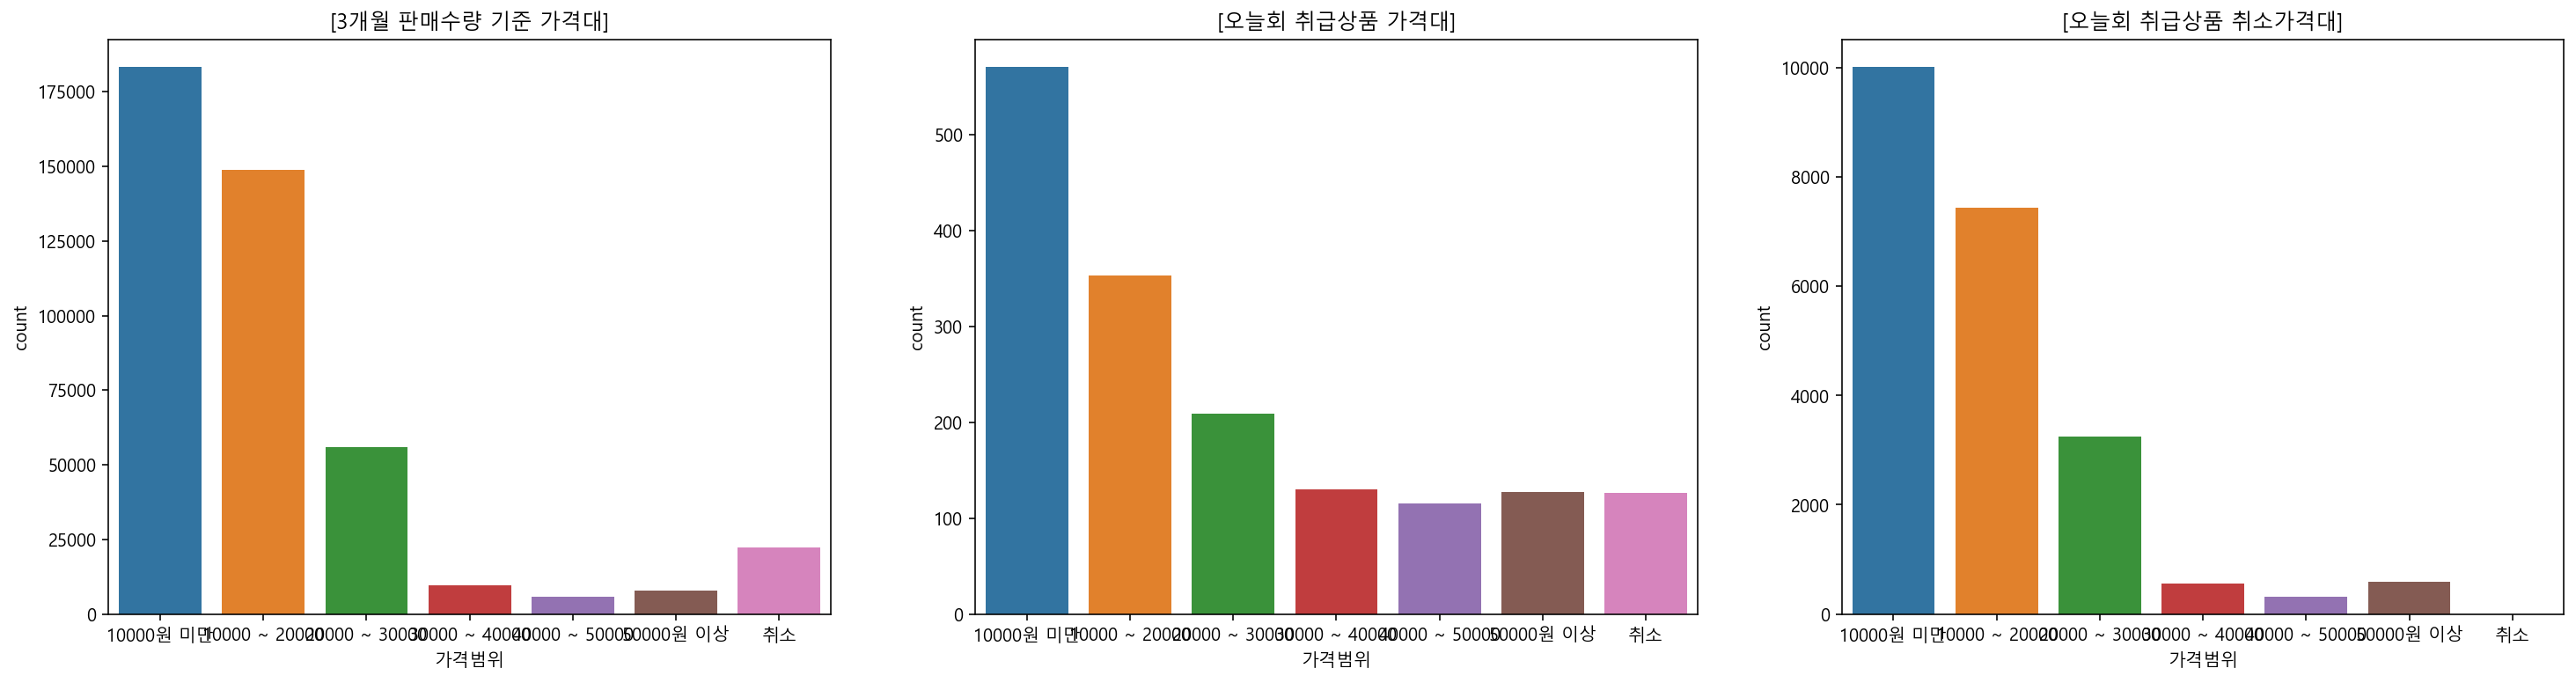

In [23]:
order = ['10000원 미만', '10000 ~ 20000', '20000 ~ 30000',  '30000 ~ 40000',  '40000 ~ 50000', '50000원 이상','취소']
쿠폰사용 = train_주문내역_수정_판매가조정[train_주문내역_수정_판매가조정["쿠폰사용금액"] > 0]

취소완료건 = train_주문내역_수정_판매가조정[train_주문내역_수정_판매가조정["상품상태"] == "취소완료"]
취소완료건["SKU 판매가(절대값)"] = abs(취소완료건["SKU 판매가"])
취소완료건["가격범위"] = 취소완료건["SKU 판매가(절대값)"].apply(divide_price_ratio)


fig = plt.figure(figsize = [25,6])
ax1 = fig.add_subplot(1,3,1)
ax1 = sns.countplot(x = "가격범위", data =train_주문내역_수정_판매가조정, order =order )
ax1 = plt.title("[3개월 판매수량 기준 가격대]")

ax1 = fig.add_subplot(1,3,2)
ax1 = sns.countplot(x = "가격범위", data =train_종류파악,  order =order)
ax1 = plt.title("[오늘회 취급상품 가격대]")

ax1 = fig.add_subplot(1,3,3)
ax1 = sns.countplot(x = "가격범위", data =취소완료건, order =order )
ax1 = plt.title("[오늘회 취급상품 취소가격대]")

#### **2. SUM기준 가격대별 매출 대비 취소액 비교**

<Figure size 720x360 with 0 Axes>

<AxesSubplot:xlabel='가격범위', ylabel='SKU 판매가'>

<AxesSubplot:xlabel='가격범위', ylabel='SKU 판매가(절대값)'>

Text(0.5, 1.0, 'New customer prefernece')

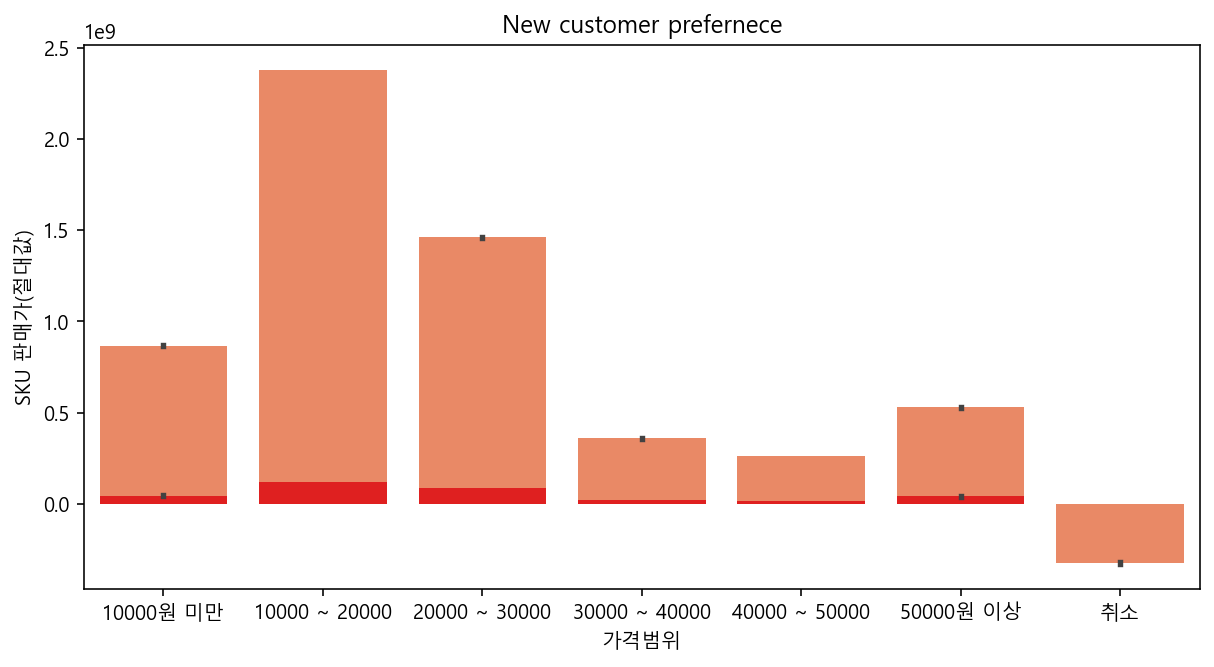

In [24]:
plt.figure(figsize = [10,5])
sns.barplot(x = "가격범위", y= "SKU 판매가", data =train_주문내역_수정_판매가조정, order =order,  estimator=sum, color = "coral")
sns.barplot(x = "가격범위", y ="SKU 판매가(절대값)",  data =취소완료건, order =order, estimator=sum,  color = "red")
plt.title("New customer prefernece")

#### **3. 가격대별 쿠폰사용 비중**

<AxesSubplot:>

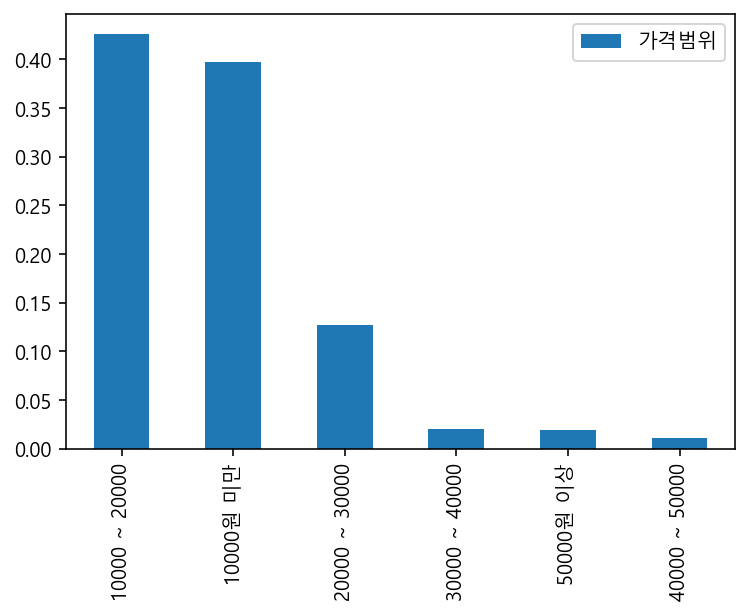

In [25]:
쿠폰사용 = train_주문내역_수정_판매가조정[train_주문내역_수정_판매가조정["쿠폰사용금액"] > 0]
pd.DataFrame(쿠폰사용["가격범위"].value_counts(normalize=True)).plot.bar()

#### **4. 증정상품 가격대 및 비율 비교**

In [40]:
xxx = train_종류파악["판매가"] == 0
yyy = train_종류파악["매입가"] > 0

train_종류파악_판매매입가 = train_종류파악[xxx & yyy]

print("증정상품 매입가 1000원 이상은 전체 증정상품 비중 대비 :", round( train_종류파악_판매매입가[train_종류파악_판매매입가["매입가"] >= 1000].shape[0] / train_종류파악_판매매입가.shape[0] , 2))

증정상품 매입가 1000원 이상은 전체 증정상품 비중 대비 : 0.37


- 1000원 이상 증정상품 상위 10개 리스트

In [55]:
train_종류파악_판매매입가[train_종류파악_판매매입가["매입가"] >= 1000].sort_values("매입가",  ascending = False).head(10)

,id,sku명,sku코드,종류,sku 생성시점,판매가,매입가,가격범위
954,9689,이베리코선물세트 900g 3구 (갈비살+배꼽살(삼겹살)+항정살),PF037FD5,당일입고,2021-02-26 16:01:31,0,24000,취소
955,9688,1등급 한우 소사골 선물세트 (3kg),PF037FD4,당일입고,2021-02-26 16:01:22,0,20000,취소
1252,7315,폰티 레드와인 식초,PM030NS004,상온,2020-05-12 13:45:56,0,13500,취소
1251,7316,폰트 화이트 와인식초,PM030NS003,상온,2020-05-12 13:45:59,0,13500,취소
925,9957,[배민] 페루바다 성게알,PM063FS17,냉동,2021-03-22 19:32:17,0,11000,취소
706,11581,[제주]물회구성품(증정용),PM072RD57,당일입고,2021-05-26 15:42:08,0,10900,취소
700,11588,[서울]한치구성품,PM072RD58,당일입고,2021-05-26 15:45:24,0,8050,취소
702,11586,[포항]오징어구성품,PF039RD32,당일입고,2021-05-26 15:42:48,0,7850,취소
1315,7025,케익띠(무스롤),SE001NS004,상온,2020-04-27 00:19:40,0,7000,취소
698,11618,[서울]문어구성품,PM072RD59,당일입고,2021-05-26 18:18:24,0,6930,취소


- 1000원 이상 증정상품 상위 10개 리스트

In [56]:
train_종류파악_판매매입가[train_종류파악_판매매입가["매입가"] >= 1000].sort_values("매입가",  ascending = True).head(10)

,id,sku명,sku코드,종류,sku 생성시점,판매가,매입가,가격범위
260,13576,소스4종,SM007ND36,당일입고,2021-09-06 16:38:31,0,1150,취소
1498,6821,[오늘회] 서더리 야채,AZSR102,냉장,2020-04-27 00:19:39,0,1184,취소
1366,6981,E-3095(플라스틱),SM001NS010,상온,2020-04-27 00:19:40,0,1190,취소
921,9964,[배민] 경기 추청으로 만든 초밥 10pcs,PM006FS7,냉동,2021-03-22 19:34:31,0,1650,취소
250,13588,물회육수(증정용),SM007FD43,당일입고,2021-09-06 16:39:08,0,1800,취소
891,10362,물회육수(증정용),SM007FD42,당일입고,2021-04-18 22:43:06,0,1800,취소
259,13577,찜용 손질 야채,SM007ND37,당일입고,2021-09-06 16:38:37,0,2000,취소
3,14052,[포항]물회육수(증정용),SM007RD47,당일입고,2021-09-28 16:03:10,0,2000,취소
223,13627,서더리용 야채,SM007ND54,당일입고,2021-09-06 17:01:40,0,2100,취소
300,13531,쌈야채,SM007ND004,당일입고,2021-09-06 16:02:20,0,2560,취소


**[Business Strategy]**

**- 10,000원~ 20,000원 위주 상품 SKU수량 확대해도 괜찮음. 취급 상황, 쿠폰 비중, 판매량, 취소금액 비교 등등을 보았을 때 10000~20000원 단가는 고객의 저항감이 적다는 판단. 10000원 미만 상품 비중 위 단계 금액부분으로 올리는 동시에 3만원 이상 가격대 상품부터는 어느정도 조정이 필요해 보임**

**- 20,000원  ~ 30,000원 대 상품들이 SKU수량 대비 판매율이 저조함. 쿠폰 빈도수가 적어서 그럴 수도 있지만 11프로 정도면 적은 것도 아님. 1) 오늘회 고객들의 가격 저항선이 20,000원대 이상 부터인건지 2) 쿠폰의 효과로 인한 3개월치 판매량이 저가상품 위주로 유입이 된건지 3) 상품의 퀄리티 및 기타 문제가 있는지 4) 묶음 판매가 많은 오늘회의 특성상 묶음 판매 기준의 저항선이 되는지(ex, 묶어서 2만원 이상 구입이 완료되면 이후 2만원짜리 상품을 외면할 수 있음, 혹은 2만원 하나 살빠엔 만원짜리 2개 사겠다는 고객마인드 일 수도 있음) -> 관련건은 고객 묶음 판매 평균단가가 어느정도 되는지 분석하면 파악 가능할 것으로 보임**


**- 판매가 0인데 매입가는 있는 증정상품 및 부가상품에 대한 이슈를 정리해주었으면 함. 1000원 이하는 몰라도 그 이상 상품이 생각보다 많음. 관련 건들은 비용 차원에서 논의를 해주었으면 함.**


**- 가격범위 기준을 명확하게 나누어서 진행했으면 함. 지금은 단순하게 만원단위로 나누었는데 분명히 가격을 결정하는 지점이 있을 것으로 보임**

### **회귀분석**


**[방향성]**

- 데이터 표준화 - StandardScaler 통해 오버플로우(overflow)나 언더플로우(underflow) 방지 하고, 독립 변수의 공분산 행렬의 조건수(condition number 최적화 과정에서의 안정성 및 수렴 속도를 향상
- 전체 데이터 기준 0.75 / 0.25 비중으로 데이터를 분산 시킨후 train, test 데이터 생성하여 train 예측값으로 test 결과값 보기
- 회귀분석 툴을 활용하고 / 'mean_squared_error' 로 예측결과 적용
- 각 독립변수들이 종속변수에 어떠한 영향 끼치는지 분석

In [28]:
## 별도작업

data = pd.get_dummies(train_주문내역_수정_판매가조정["가격범위"])
train_주문내역_수정_판매가조정 = pd.concat([train_주문내역_수정_판매가조정, data], axis = 1)

train_주문내역_수정_판매가조정["주문시간"] = pd.to_datetime(train_주문내역_수정_판매가조정["주문시간"])

train_주문내역_수정_판매가조정["year"] = train_주문내역_수정_판매가조정["주문시간"].dt.year
train_주문내역_수정_판매가조정["month"] = train_주문내역_수정_판매가조정["주문시간"].dt.month
train_주문내역_수정_판매가조정["day"] = train_주문내역_수정_판매가조정["주문시간"].dt.day
train_주문내역_수정_판매가조정["hour"] = train_주문내역_수정_판매가조정["주문시간"].dt.hour
train_주문내역_수정_판매가조정["minute"] = train_주문내역_수정_판매가조정["주문시간"].dt.minute
train_주문내역_수정_판매가조정["second"] = train_주문내역_수정_판매가조정["주문시간"].dt.second

**[데이터 선별 & 회귀분석 작업 진행]**
- 독립변수 선별 : '매입가', '쿠폰사용금액',  '마진', '종류__냉동', '종류__냉장', '종류__당일입고', '종류__상온' ,'10000 ~ 20000', '10000원 미만','20000 ~ 30000', '30000 ~ 40000',  '40000 ~ 50000', '50000원 이상', '취소','month', 'day', 'hour', 'minute', 'second

In [29]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn import set_config
set_config(print_changed_only = False)

feature_names =  ['매입가', '쿠폰사용금액',  '마진', '종류__냉동', '종류__냉장', '종류__당일입고', '종류__상온' ,
                  '10000 ~ 20000', '10000원 미만','20000 ~ 30000', '30000 ~ 40000',  '40000 ~ 50000', '50000원 이상', '취소','month', 'day', 'hour', 'minute', 'second']

label_name = 'SKU 판매가'

X_train = train_주문내역_수정_판매가조정[feature_names]
Y_train = train_주문내역_수정_판매가조정[label_name]

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train, Y_train, test_size = 0.2,  random_state = 37)


<AxesSubplot:>

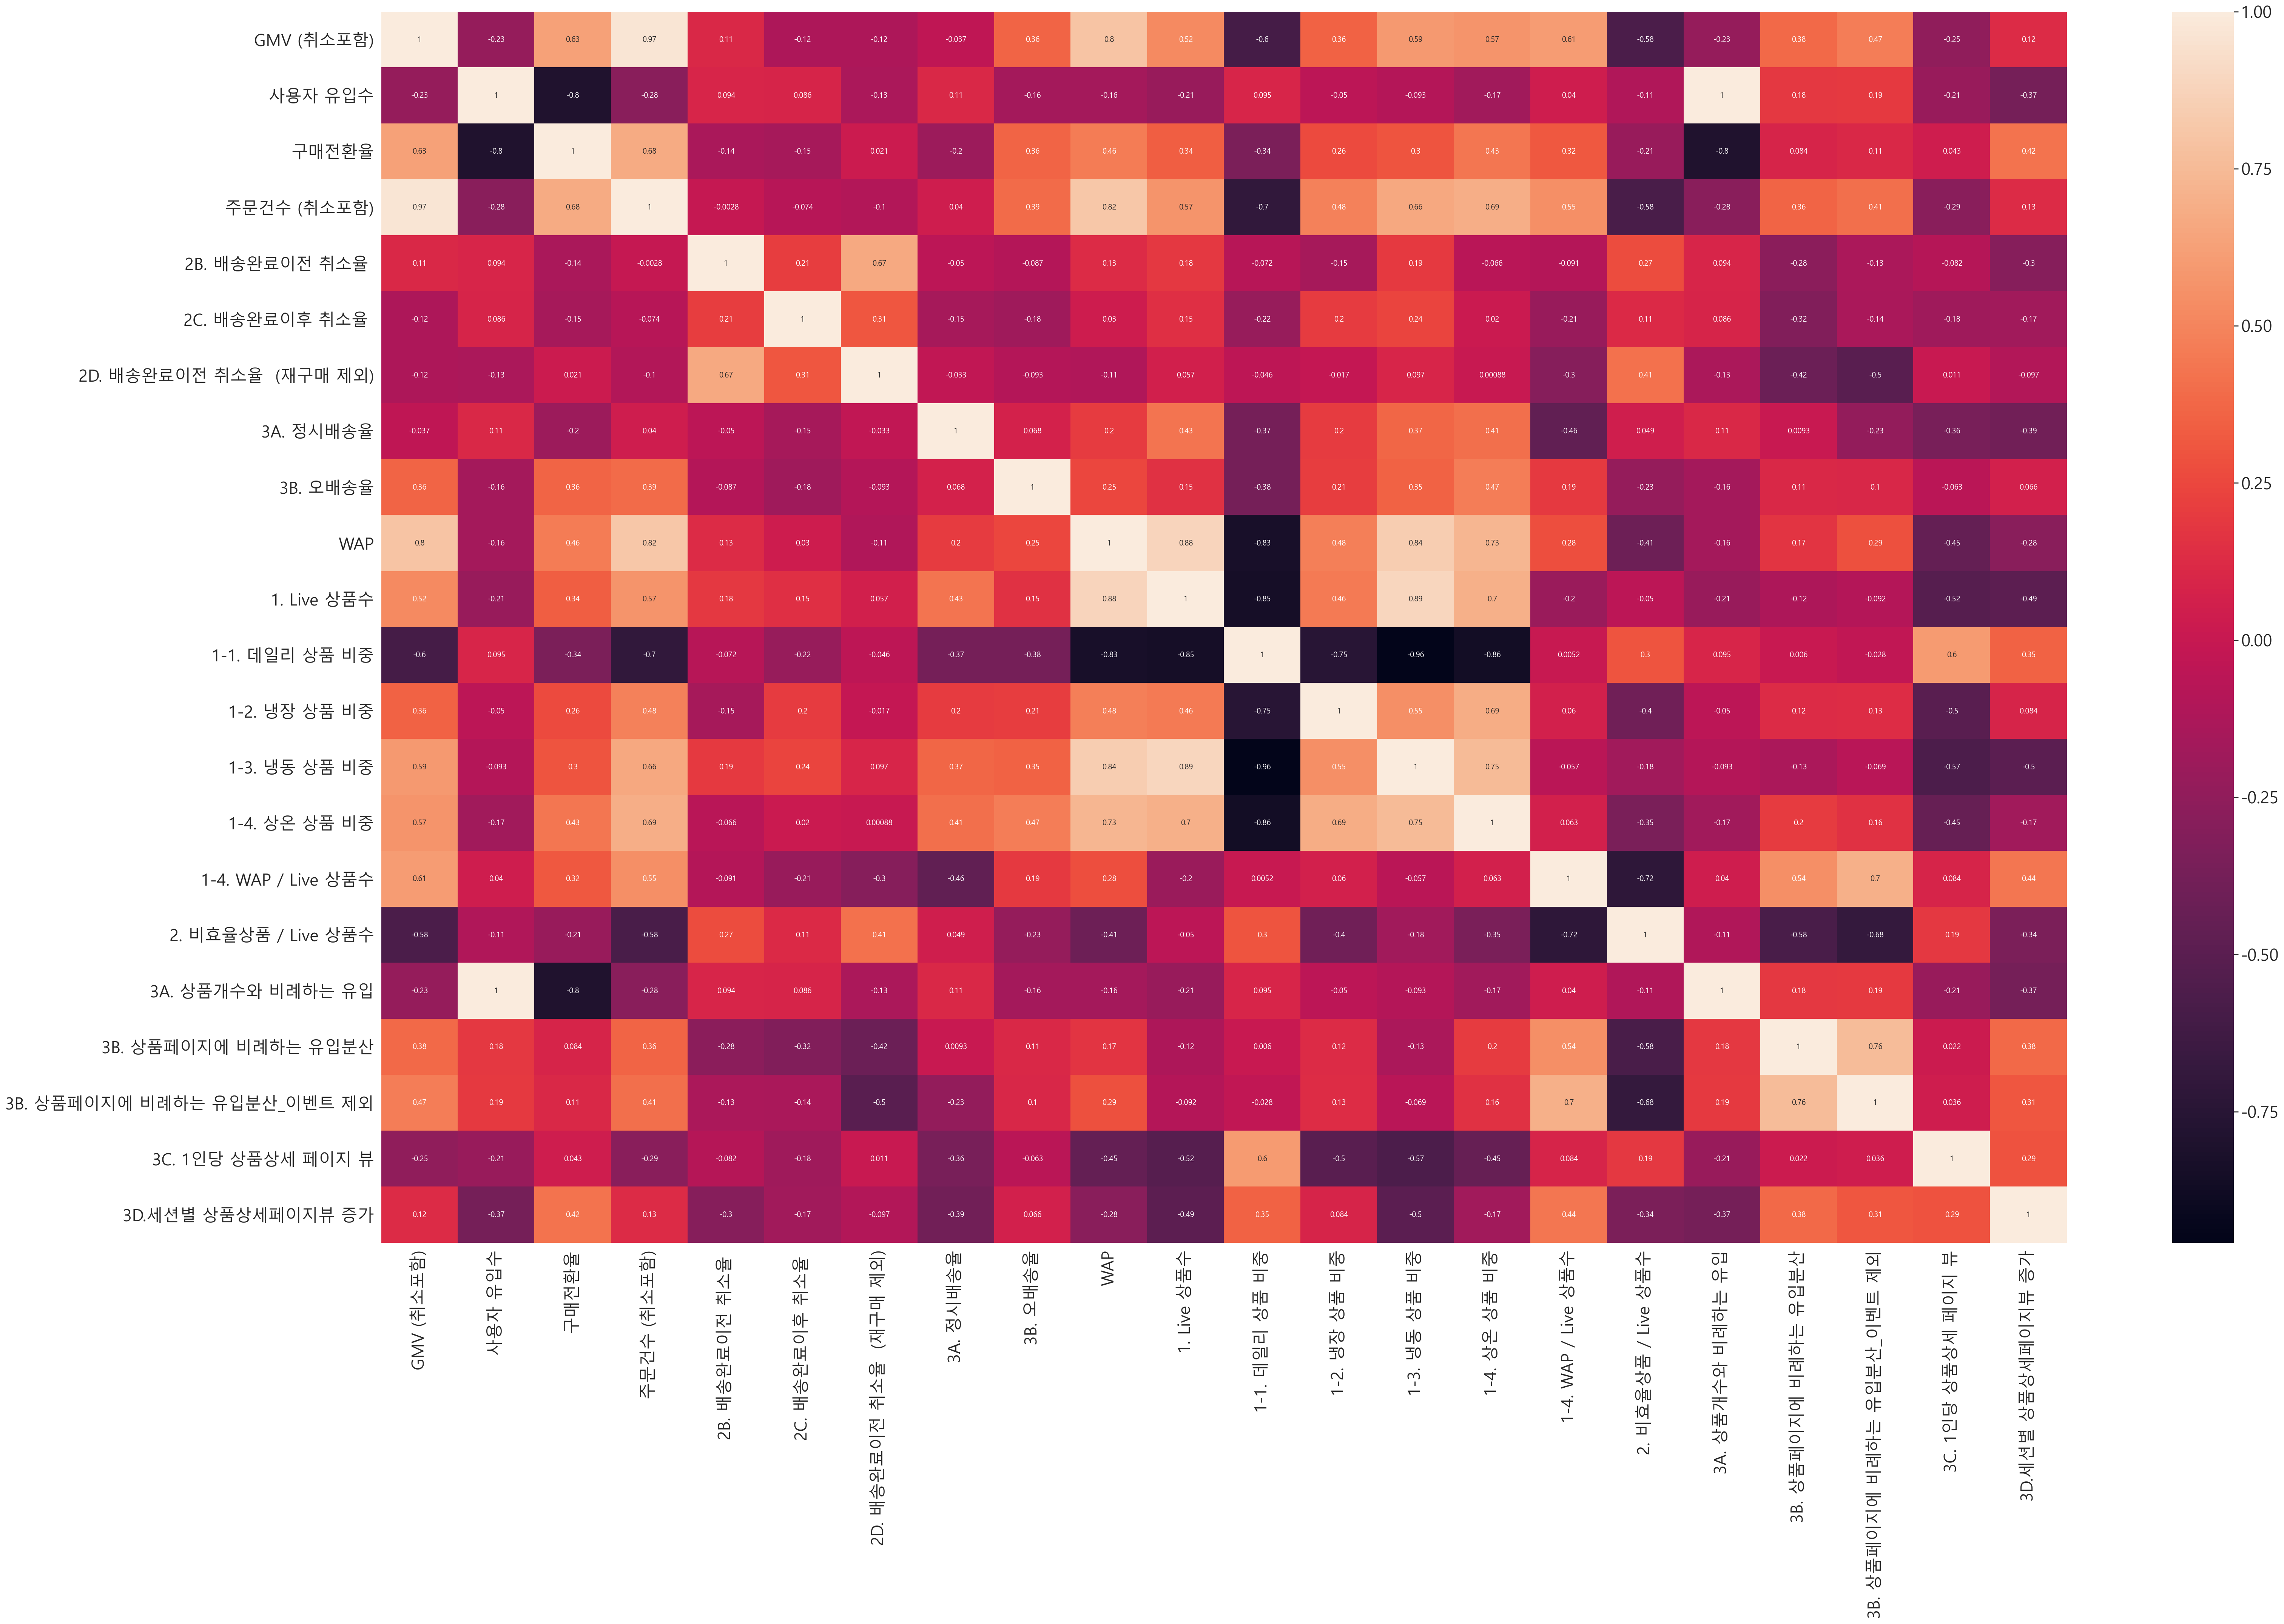

In [178]:
fig = plt.figure(figsize = [50,30])
sns.heatmap(train.corr(), annot=True)

- 회귀분석에 적용해볼 데이터 

In [31]:
X_train_t.head()

,매입가,쿠폰사용금액,마진,종류__냉동,종류__냉장,종류__당일입고,종류__상온,10000 ~ 20000,10000 ~ 20000,10000원 미만,10000원 미만,20000 ~ 30000,20000 ~ 30000,30000 ~ 40000,30000 ~ 40000,40000 ~ 50000,40000 ~ 50000,50000원 이상,50000원 이상,취소,취소,month,day,hour,minute,second
381837,900,0,690,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,7,23,5,31,0
535466,7000,11910,5900,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,7,2,13,46,0
276729,17500,0,11400,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,8,24,16,10,51
491464,700,0,290,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,7,9,13,21,0
345411,5000,0,2900,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,7,26,14,13,0


**[회귀분석]**
- 1. model 1 적용


In [35]:
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
score=mean_squared_error(y_test_t,prediction)

X_train_t = StandardScaler().fit(X_train_t).transform(X_train_t)
X_test_t = StandardScaler().fit(X_test_t).transform(X_test_t)

## modeling1 
model = RandomForestRegressor( n_estimators=300)
model.fit(X_train_t, y_train_t)

prediction = model.predict(X_test_t)

from sklearn.metrics import mean_squared_error
score=mean_squared_error(y_test_t,prediction)
score=np.sqrt(score)
print(" RandomForestRegressor 의 mean_squared_error값은 : " , score)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

 RandomForestRegressor 의 mean_squared_error값은 :  391.15838681312863


**RandomForestRegressor 의 mean_squared_error값은 :  391.15838681312863**

In [36]:
## modeling2
model_light = LGBMRegressor( n_estimators=300)
model_light.fit(X_train_t, y_train_t)

prediction = model_light.predict(X_test_t)

from sklearn.metrics import mean_squared_error
score1=mean_squared_error(y_test_t,prediction)
score1=np.sqrt(score)
print(" LGBMRegressor 의 mean_squared_error값은 : " , score1)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

 LGBMRegressor 의 mean_squared_error값은 :  19.777724510497375


**LGBMRegressor 의 mean_squared_error값은 :  19.777724510497375**

- RandomForestRegressor

In [485]:
import eli5 
from eli5.sklearn import PermutationImportance 

perm = PermutationImportance(model, scoring = "neg_mean_squared_error", random_state = 22).fit(X_test_t, y_test_t) 
eli5.show_weights(perm,  feature_names = X_train.columns.tolist())

Weight,Feature
3809746821.6615 ± 69695260.6034,매입가
3706684693.6164 ± 50430786.6472,마진
94622940.3145 ± 16831172.6528,50000원 이상
1861869.1018 ± 25325.6428,10000 ~ 20000
413664.6899 ± 1767.3589,10000원 미만
242095.1476 ± 4224.4501,20000 ~ 30000
127428.6740 ± 3590.9708,30000 ~ 40000
46718.3647 ± 1590.2877,취소
14096.4864 ± 99.2602,40000 ~ 50000
11172.4190 ± 5029.3966,종류__당일입고


- LGBMRegressor

In [496]:
perm = PermutationImportance(model_light, scoring = "neg_mean_squared_error", random_state = 22).fit(X_test_t, y_test_t) 
eli5.show_weights(perm,  feature_names = X_train.columns.tolist())

Weight,Feature
367528713.2093 ± 5975437.8394,마진
47115513.0323 ± 1587689.6497,매입가
3951726.2271 ± 88556.3214,10000 ~ 20000
3815522.4209 ± 47344.7542,20000 ~ 30000
452385.8389 ± 39827.8766,종류__냉동
377606.8516 ± 4960.2498,30000 ~ 40000
64385.9983 ± 42426.5319,second
61186.8847 ± 16100.4101,month
15979.3294 ± 827.1255,50000원 이상
5668.1485 ± 1168.0894,40000 ~ 50000




**[Business Strategy]**

**- 마진, 매입가가 영향을 많이 끼치는것으로 나오는데, 이 데이터 자체가 판매액보다는 각 raw데이터 당 판매 1개를 기준으로 판단하는 것이기 때문에 '가격'자체에 영향을 미치는 변수도 있다는 점에서 위 두개는 적절한 것은 아니다. 물론 마진이나 매입가가 가격을 결정하고 매출에 영향을 미치는 것은 당연하지만 현 데이터는 판매량을 보는 것이기 때문에 적절치 않음**


**- 아래 통계가 점수가 더 좋은 모델을 기반으로 회귀분석 진행한 것 -> 그 여부와 상관없이 10000~20000원대 가격대 상품들이 판매량이 많고, 전체 판매에 유의미한 영향을 끼친다는 사실을 파악할 수 있다.**



In [64]:
! jupyter nbconvert WBR_상관관계분석.ipynb --to=html --no-input

[NbConvertApp] Converting notebook WBR_상관관계분석.ipynb to html
[NbConvertApp] Writing 733041 bytes to WBR_상관관계분석.html
